Solve the 1D transport equation on the unit disk.  That is, find $\rho:\Omega \rightarrow \mathbb{R}$ such that

$$
\frac{\partial \rho}{\partial t} + \nabla \cdot \left( \rho \mathbf{v} \right) = 0 
$$
on 
$$
\Omega = \left\{ (x,y) \in \mathbb{R}^2 : x^2 + y^2 < 1 \right\}
$$
 where $\rho$ is the density and $\mathbf{v}$ is the velocity.
 
To be complete and solvable we add in dirichlet boundary conditions on $\rho(x,t)$
$$
\left.p\right|_{\partial\Omega} = \rho(x,t)
$$
Finally we need initial conditions
$$
\rho(x,t=0) = \rho_0(x).
$$

In [1]:
from proteus.iproteus import * #pull in what we need for using proteus interactively
Profiling.logLevel=3
Profiling.verbose = False
import matplotlib
matplotlib.use('svg')
%matplotlib  inline
from matplotlib  import pylab
pylab.rcParams['figure.figsize'] = 16, 12

Define the PDE by defining the coefficients

In [2]:
from NavierStokes import MassTransport
display_src(MassTransport)

```Python
class MassTransport(TransportCoefficients.TC_base):
    r"""
    The coefficients for conservative mass transport

    Conservation of mass is given by

    .. math::

       \frac{\partial\rho}{\partial t}+\nabla\cdot\left(\rho\mathbf{v}\right)=0
    """
    def __init__(self,velocityModelIndex=-1, velocityFunction=None):
        """Construct a coefficients object

        :param velocityModelIndex: The index into the proteus model list

        :param velocityFunction: A function taking as input an array of spatial
        locations :math: `x`, time :math: `t`, and velocity :math: `v`, setting
        the velocity parameter as a side effect.

        TODO: decide how the parameters interact. I think velocityFunction
        should override the velocity from another model

        """
        TransportCoefficients.TC_base.__init__(self,
                                               nc = 1,
                                               variableNames = ['rho'],
                                               mass = {0:{0:'linear'}},
                                               advection = {0:{0:'linear'}})
        self.velocityModelIndex = velocityModelIndex
        self.velocityFunction = velocityFunction
        self.c_v = {}

    def attachModels(self,modelList):
        """
        Attach the model for velocity
        """
        if self.velocityModelIndex >= 0:
            assert self.velocityModelIndex < len(modelList), \
                "velocity model index out of  range 0," + repr(len(modelList))
            self.velocityModel = modelList[self.velocityModelIndex]
            if ('velocity',0) in self.velocityModel.coefficients.q:
                v = self.velocityModel.coefficients.q[('velocity',0)]
                self.c_v[v.shape] = v
            if ('velocity',0) in self.velocityModel.coefficients.ebq:
                v = self.velocityModel.coefficients.ebq[('velocity',0)]
                self.c_v[v.shape] = v
            if ('velocity',0) in self.velocityModel.coefficients.ebqe:
                v = self.velocityModel.coefficients.ebqe[('velocity',0)]
                self.c_v[v.shape] = v
            if ('velocity',0) in self.velocityModel.coefficients.ebq_global:
                v = self.velocityModel.coefficients.ebq_global[('velocity',0)]
                self.c_v[v.shape] = v

    def evaluate(self,t,c):
        """
        Evaluate the coefficients after getting the specified velocity
        """
        if self.velocityFunction != None:
            v = self.velocityFunction(c['x'],t)
        else:
            v = self.c_v[c[('f',0)].shape]
        c[('m',0)][:] = c[('u',0)]
        c[('dm',0,0)][:] = 1.0
        c[('f',0)][...,0] = c[('u',0)]*v[...,0]
        c[('f',0)][...,1] = c[('u',0)]*v[...,1]
        c[('df',0,0)][:] = v

```


Setup the problem by method of manufactured solution.

We will introduce a specific example that we have implemented, but we use sympy to symbolically compute the source terms based on the navier stokes equation as defined above.  In order to change the solution, it is only necessary to update p and v below.

A specific solution to 1D navier-stokes equation:

$$
p(x,t) = 1 + \sin(2\pi (x-t))
$$
and
$$
v(x,t) = \sin(2\pi(x-t))\cos(2\pi(x-t))
$$
thus
$$
r(x,t) = \nabla\cdot v = 2\pi\cos(4\pi(x-t))
$$
and
$$
\begin{split}
f(x,t) = -2\pi\cos(4\pi(x-t)) &+ 4\pi\sin(2\pi(x-t))\cos^3(2\pi(x-t)) - 4\pi\sin^{3}(2\pi(x-t))\cos(2\pi(x-t))\\& + \frac{2\pi}{\rho}\cos(2\pi(x-t)) + \frac{8\pi^2\mu}{\rho}\sin(4\pi(x-t))
\end{split}
$$

Note that we are not divergence free here in 1D since that would require constant velocity.  The momentum equation must be written in the form  $\nabla\cdot(v\otimes v)$  instead of $v\cdot\nabla v$ since the second form utilizes the fact that $v$ is divergence free.

Define the python functions for evaluating the terms. Note that the x array for the quadrature points will be a multidimensional array. The last dimension will be 3 always though.  This is done using the sympy module and is easily modified to represent any manufactured solution desired.

In [3]:
#use numpy for evaluations
import numpy as np
from IPython.display import  display
from sympy.interactive import printing
printing.init_printing(use_latex=True)
# Create the manufactured solution and run through sympy 
# to create the forcing function and solutions etc
#
# Import specific sympy functions to avoid overloading 
# numpy etc functions
from sympy.utilities.lambdify import lambdify
from sympy import (symbols, 
                   simplify,
                   diff)
from sympy.functions import (sin as sy_sin,
                             cos as sy_cos,
                             atan2 as sy_atan2,
                             sqrt as sy_sqrt)
from sympy import pi as sy_pi

# use xs and ts to represent symbolic x and t
xs,ys,ts = symbols('x y t')

# viscosity coefficient
mu = 1.0

# Given solution: (Modify here and if needed add more sympy.functions above with 
#                  notation sy_* to distinguish as symbolic functions)
rs = sy_sqrt(xs*xs + ys*ys)
thetas = sy_atan2(ys,xs)
rhos = 2 + rs*sy_cos(thetas-sy_sin(ts))
#seems these are equivalent
#rhos = 2 + xs*sy_cos(sy_sin(ts))+ys*sy_sin(sy_sin(ts))
ps = sy_sin(xs)*sy_sin(ys)*sy_sin(ts)
us = -ys*sy_cos(ts)
vs = xs*sy_cos(ts)

# manufacture the source terms:

f1s = simplify((rhos*(diff(us,ts) + us*diff(us,xs) + vs*diff(us,ys)) + diff(ps,xs) - diff(mu*us,xs,xs) - diff(mu*us,ys,ys)))
f2s = simplify((rhos*(diff(vs,ts) + us*diff(vs,xs) + vs*diff(vs,ys)) + diff(ps,ys) - diff(mu*vs,xs,xs) - diff(mu*vs,ys,ys)))


# use lambdify to convert from sympy to python expressions
pl = lambdify((xs, ys, ts), ps, "numpy")
ul = lambdify((xs, ys, ts), us, "numpy")
vl = lambdify((xs, ys, ts), vs, "numpy")
rhol = lambdify((xs, ys, ts), rhos, "numpy")
f1l = lambdify((xs, ys, ts), f1s, "numpy")
f2l = lambdify((xs, ys, ts), f2s, "numpy")

# convert python expressions to the format we need for multidimensional x values
def ptrue(x,t): 
    return pl(x[...,0],x[...,1],t)

def utrue(x,t):
    return ul(x[...,0],x[...,1],t)

def vtrue(x,t):
    return vl(x[...,0],x[...,1],t)

def rhotrue(x,t):
    return rhol(x[...,0],x[...,1],t)

def f1true(x,t):
    return f1l(x[...,0],x[...,1],t)

def f2true(x,t):
    return f2l(x[...,0],x[...,1],t)

def velocityFunction(x,t):
    return np.vstack((utrue(x,t)[...,np.newaxis].transpose(),
                      vtrue(x,t)[...,np.newaxis].transpose())
                    ).transpose()

display(rhos)
display(us)
display(vs)

Define the physical input to the model

In [4]:
physics = default_p
physics.name = "mass_transport"
physics.nd = 2; #One dimension

unitCircle = True
if unitCircle:
    #spatial domain
    boundaries=['left','right','bottom','top','front','back']
    boundaryTags=dict([(key,i+1) for (i,key) in enumerate(boundaries)])
    #
    #set up a cicular domain
    #
    from math import pi, ceil, cos, sin
    he = 2.0*pi/50.0
    nvertices = nsegments = int(ceil(2.0*pi/he))
    dtheta = 2.0*pi/float(nsegments)
    vertices= []
    vertexFlags = []
    segments = []
    segmentFlags = []
    for i in range(nsegments):
        theta = pi/2.0 - i*dtheta
        vertices.append([0.0+cos(theta),0.0+sin(theta)])
        if i in [nvertices-1,0,1]:
            vertexFlags.append(boundaryTags['top'])
        else:
            vertexFlags.append(boundaryTags['bottom'])
        segments.append([i,(i+1)%nvertices])
        if i in [nsegments-1,0]:
            segmentFlags.append(boundaryTags['top'])
        else:
            segmentFlags.append(boundaryTags['bottom'])
    domain = Domain.PlanarStraightLineGraphDomain(vertices=vertices,
                                                      vertexFlags=vertexFlags,
                                                      segments=segments,
                                                      segmentFlags=segmentFlags)
    #go ahead and add a boundary tags member
    domain.boundaryTags = boundaryTags
    domain.writePoly("mesh")
    #
    #finished setting up circular domain
    #
    triangleOptions="VApq30Dena%8.8f" % ((he**2)/2.0,)

physics.domain=domain

# Integrate from t=0 to t=1
physics.T = 10.0

#the object for evaluating the coefficients   
physics.coefficients=MassTransport(velocityFunction=velocityFunction)

#this function's job is to return another function holding the Dirichlet boundary conditions 
# wherever they are set

def getDBC_rho(x,flag):
    if flag in [boundaryTags['bottom'],
                boundaryTags['top']]:
        return lambda x,t: rhotrue(x,t)
    
def getNone(x,flag):
    return None

class getIBC_rho:
    def __init__(self):
        self.rhotrue=rhotrue
        pass
    def uOfXT(self,x,t):
        return self.rhotrue(x,t)
    
physics.initialConditions = {0:getIBC_rho()}

physics.dirichletConditions = {0:getDBC_rho}

physics.advectiveFluxBoundaryConditions = {0:getNone}#
physics.fluxBoundaryConditions = {0:'outFlow'}

Define the numerics input for the problem

In [5]:
numerics=default_n
#piecewise linears
numerics.femSpaces = {0:FemTools.C0_AffineQuadraticOnSimplexWithNodalBasis}#density space

numerics.timeIntegration = TimeIntegration.BackwardEuler_cfl
numerics.timeIntegration = TimeIntegration.VBDF
numerics.timeOrder = 2
numerics.stepController  = StepControl.Min_dt_cfl_controller
numerics.runCFL= 0.99
nFrames = 41
dt = physics.T/(nFrames-1)
numerics.tnList = [i*dt for i in range(nFrames)]

#Quadrature rules for elements and element  boundaries
numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,5)
numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,5)
#number of nodes in the x and y direction
numerics.triangleOptions  = triangleOptions
numerics.subgridError = SubgridError.Advection_ASGS(physics.coefficients,
                                                    physics.nd,
                                                    lag=False)
#numerics.shockCapturing = ShockCapturing.ResGradQuadDelayLag_SC(physics.coefficients,
#                                                                physics.nd,
#                                                                lag = True,
#                                                                nStepsToDelay=1)
#numerics.nny= 41

#matrix type
numerics.numericalFluxType = NumericalFlux.StrongDirichletFactory(physics.fluxBoundaryConditions)
#numerics.numericalFluxType = MixedDarcy_exterior
#numerics.numericalFluxType = NumericalFlux.Advection_DiagonalUpwind_Diffusion_IIPG_exterior
#numerics.numericalFluxType = NumericalFlux.Advection_Diagonal_average
numerics.matrix = LinearAlgebraTools.SparseMatrix
#use petsc solvers wrapped by petsc4py
#numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
#numerics.levelLinearSolver = LinearSolvers.KSP_petsc4py
#using petsc4py requires weak boundary condition enforcement
#can also use our internal wrapper for SuperLU
numerics.multilevelLinearSolver = LinearSolvers.LU
numerics.levelLinearSolver = LinearSolvers.LU

numerics.multilevelNonlinearSolver = NonlinearSolvers.Newton
numerics.levelNonlinearSolver = NonlinearSolvers.Newton

#linear solve rtolerance

numerics.linTolFac = 0.001
numerics.tolFac = 0.0

numerics.l_atol_res = 1.0e-5
numerics.nl_atol_res = 1.0e-5
numerics.periodicDirichletConditions=None
#
# split operator options (trivial since we're not splitting)
#
so = default_so
so.name = physics.name
so.sList=[default_s]
so.tnList = numerics.tnList

Construct a NumericalSolution object and solve the problem

In [6]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
ns.calculateSolution('run1')

TriangleBaseMesh nbase=1 baseFlags= VApq30Dena0.00789568 
fluxBoundaryCondition_components set([0])


False

Plot an animation of the solution and errors with matplotlib over time $t=0$ to $t=T$. Only works for $C^0 P^1$ right now

In [7]:
import tables
h5 = tables.openFile("mass_transport0.h5","r") # change this to use physics.name + "0.h5"


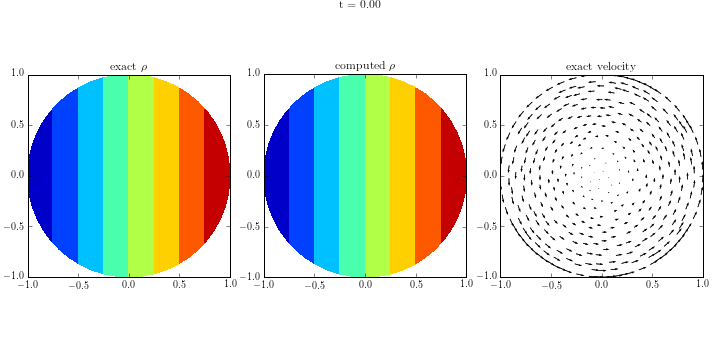
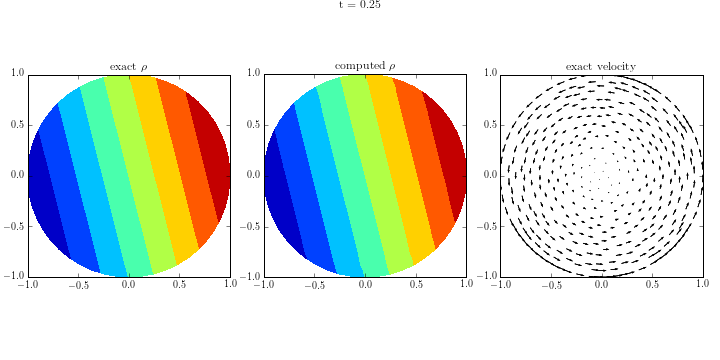
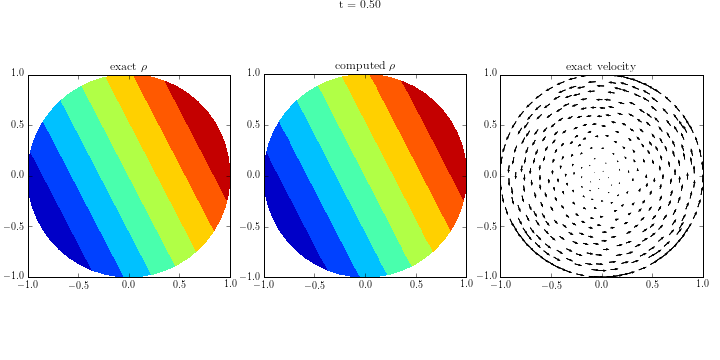
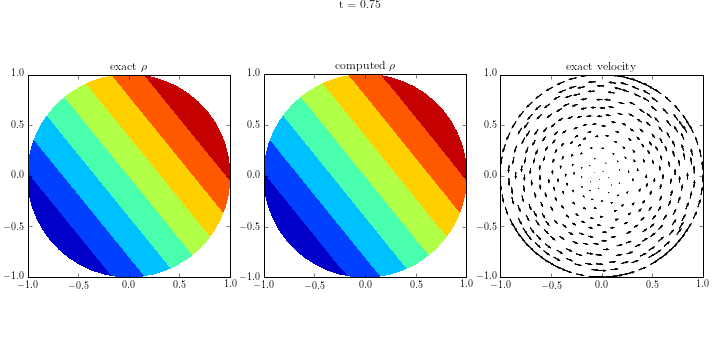
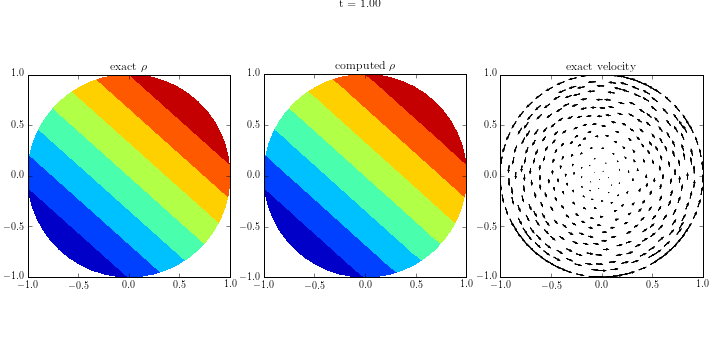
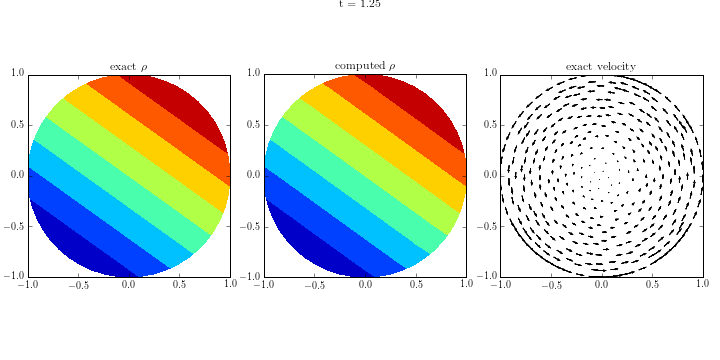
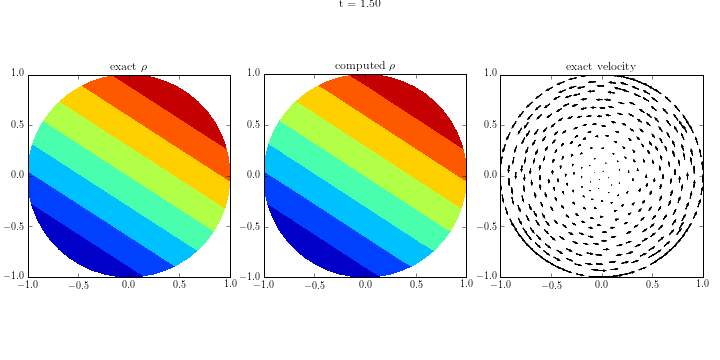
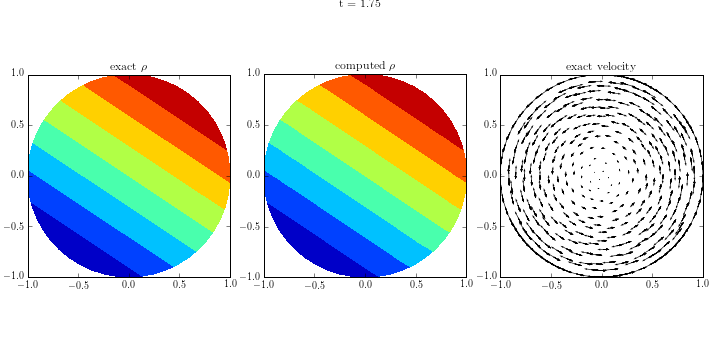
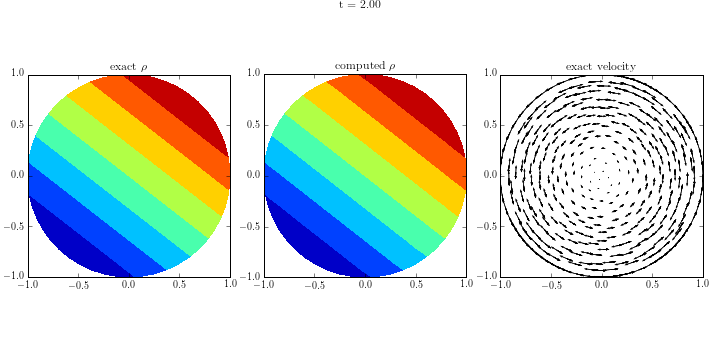
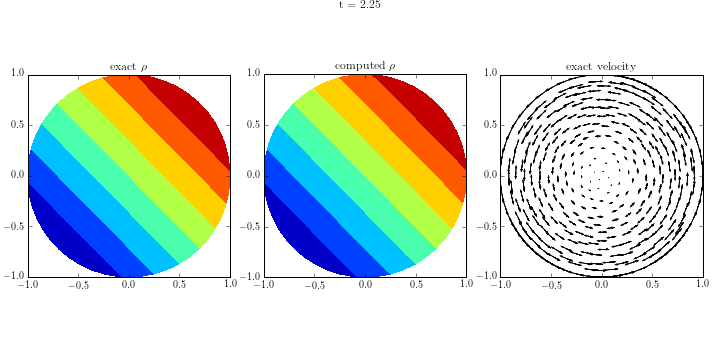
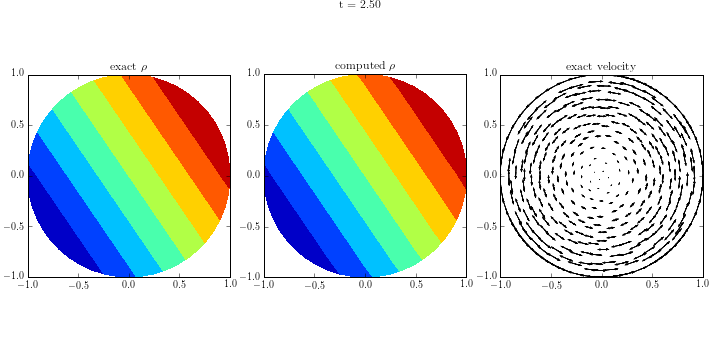
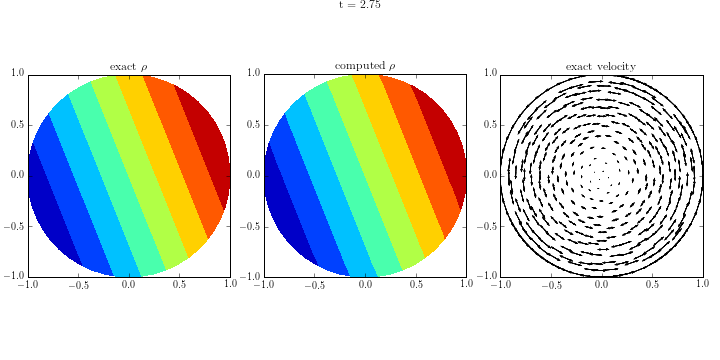
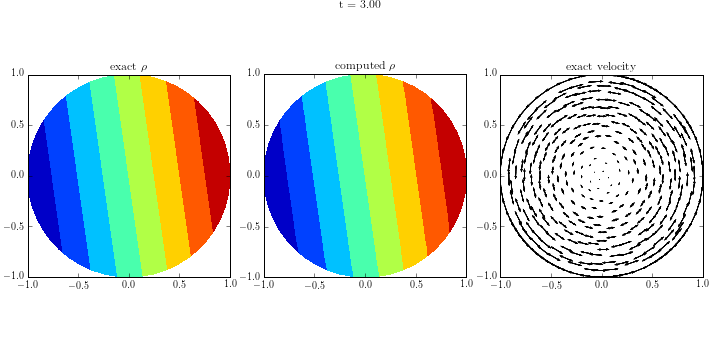
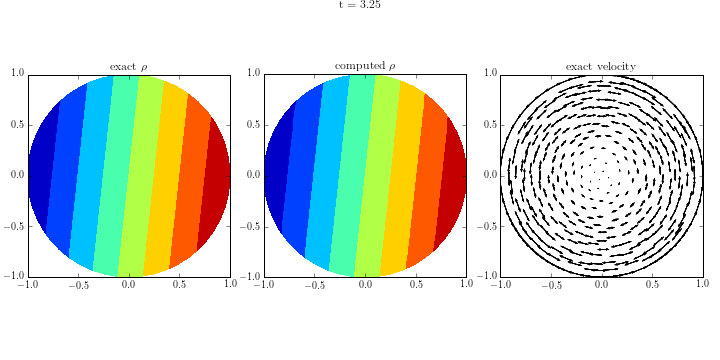
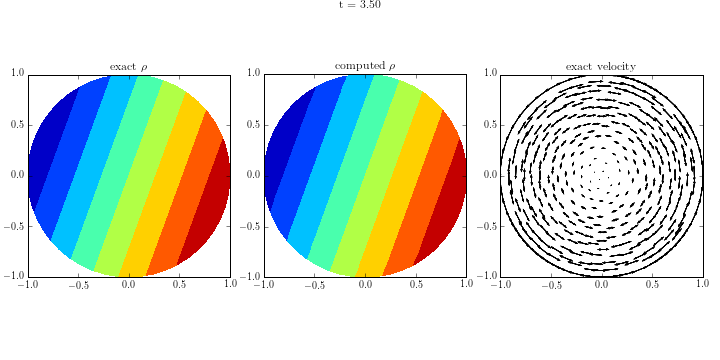
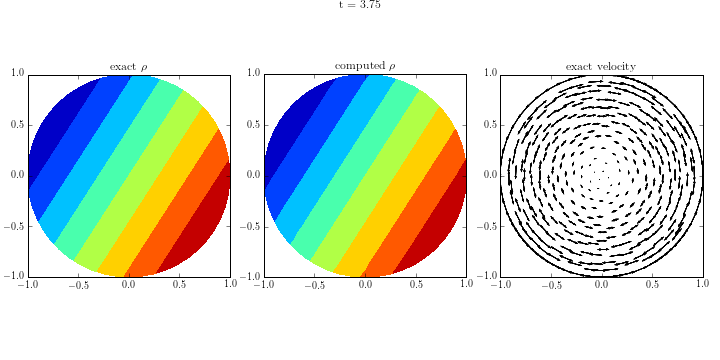
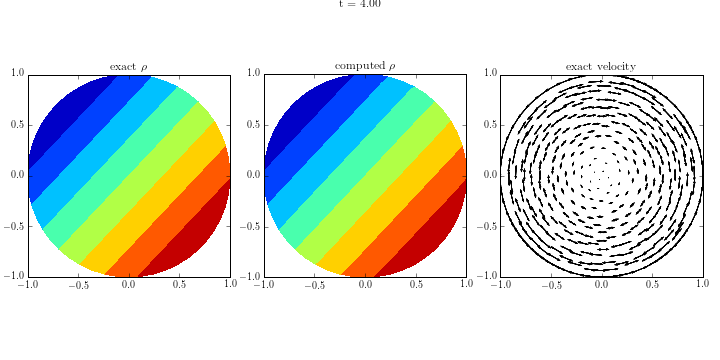
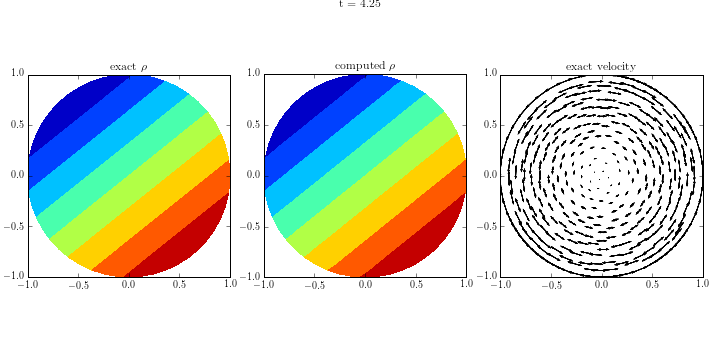
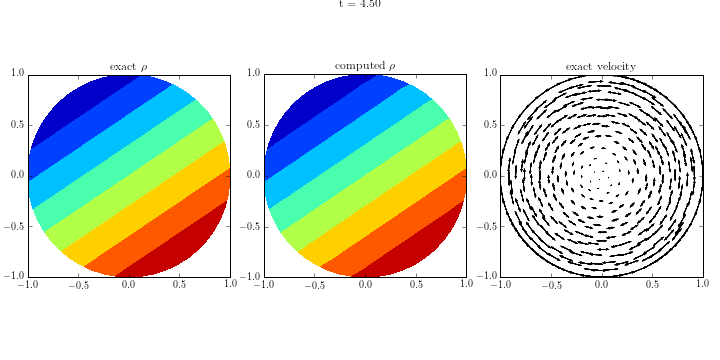
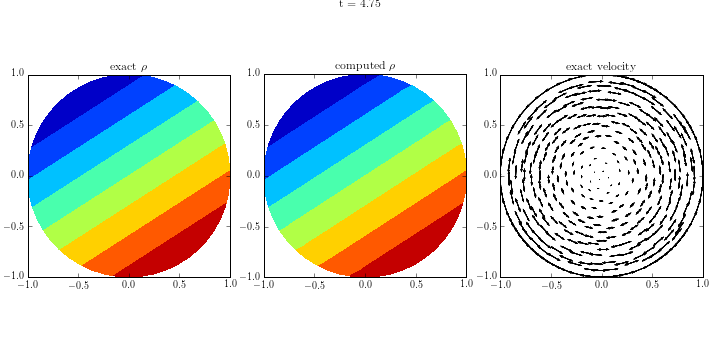
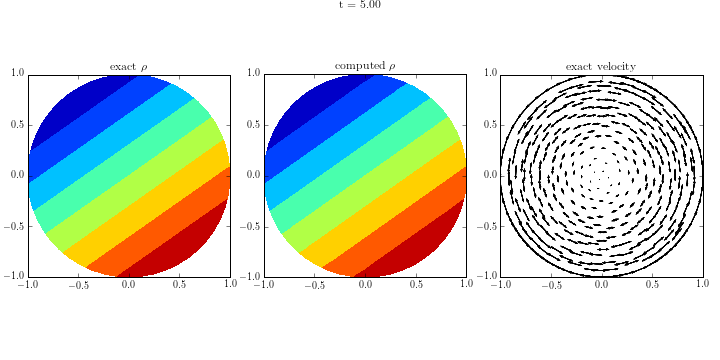
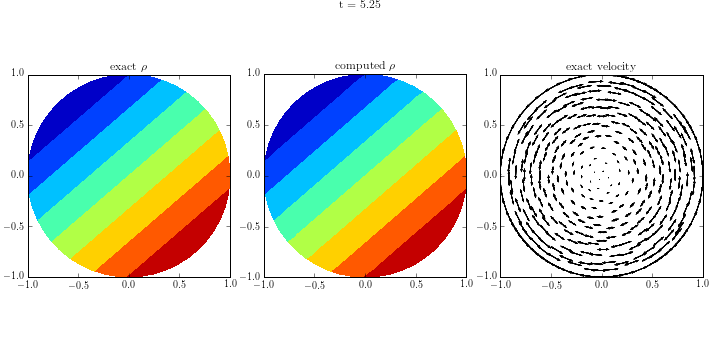
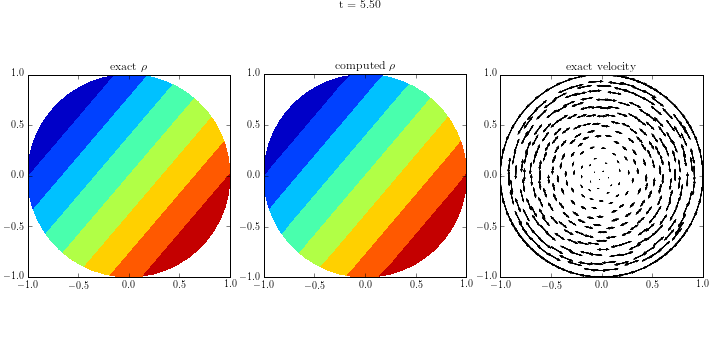
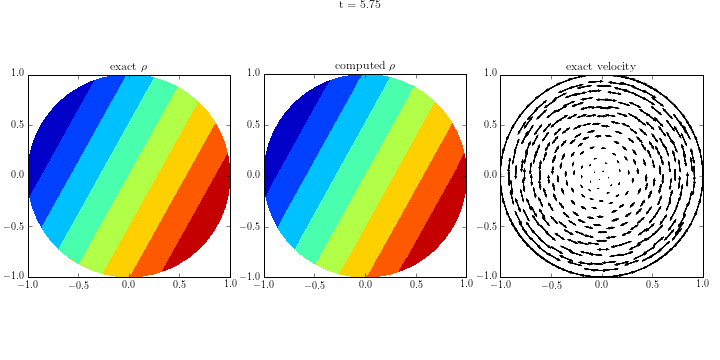
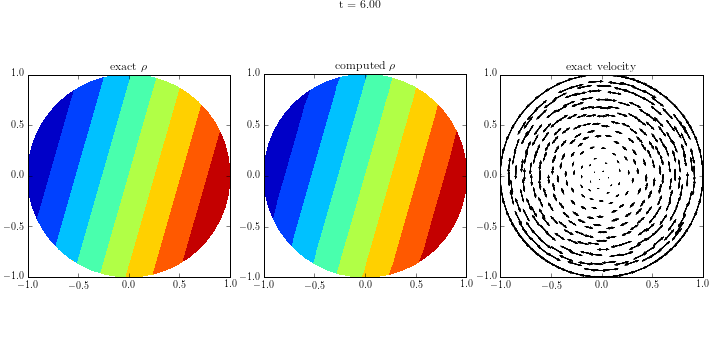
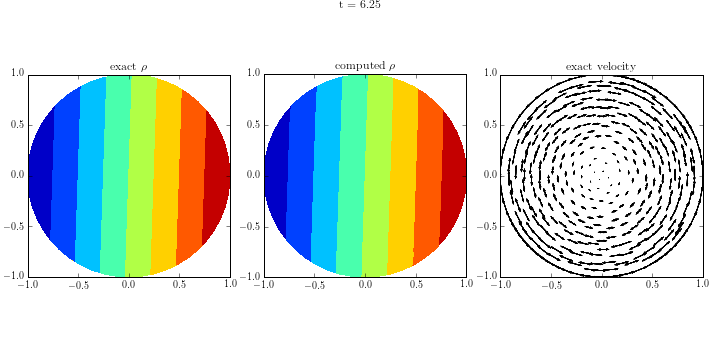
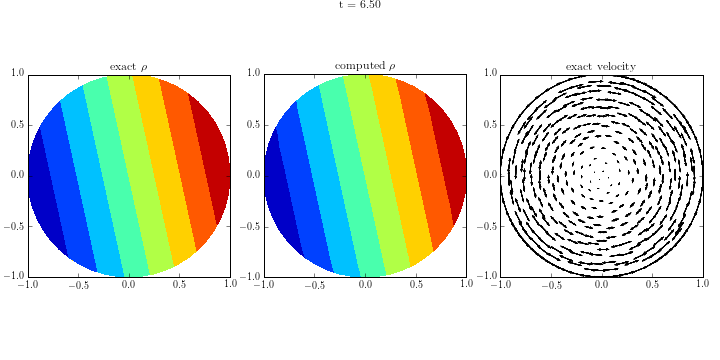
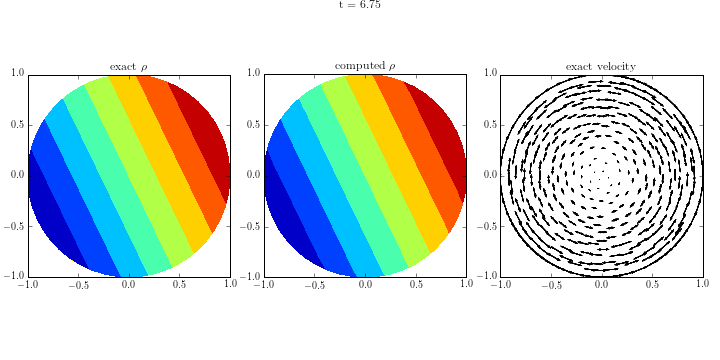
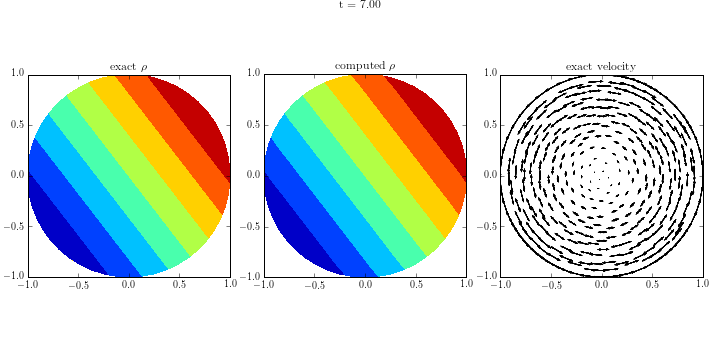
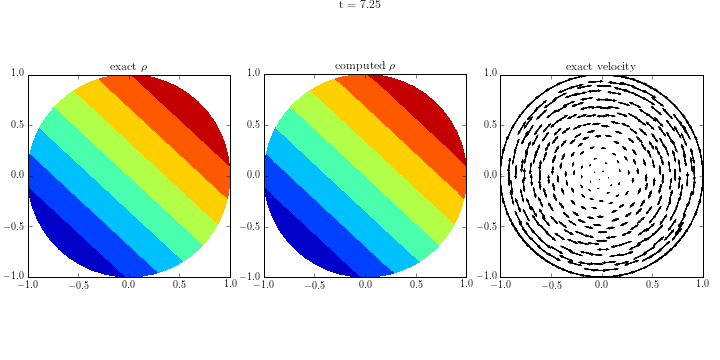
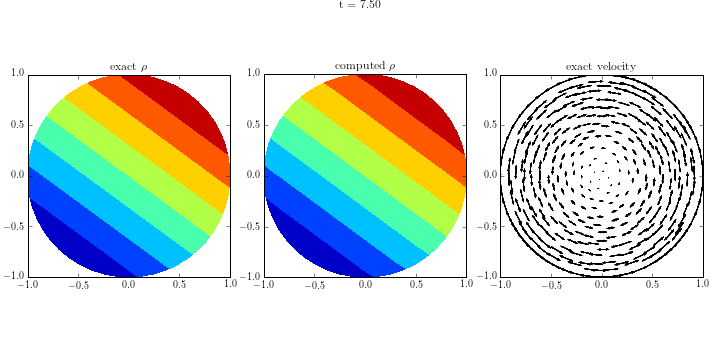
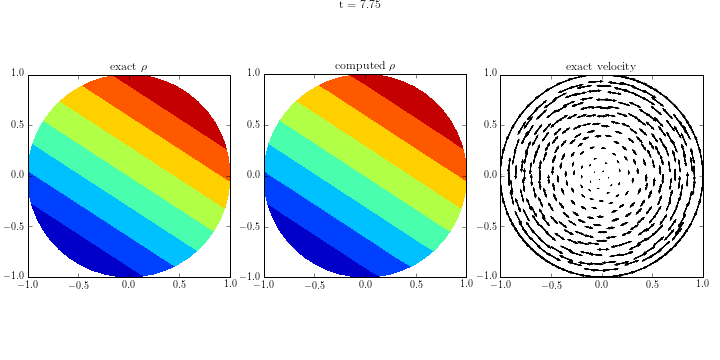
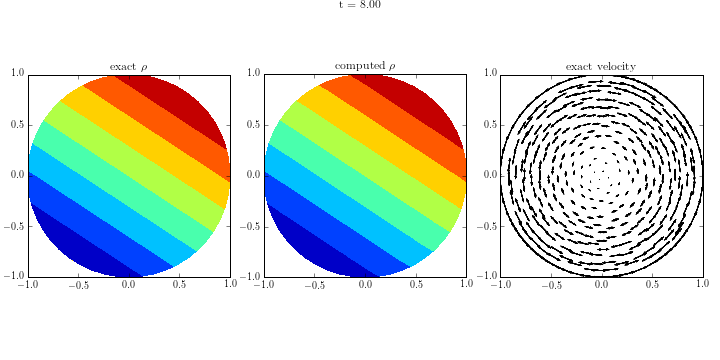
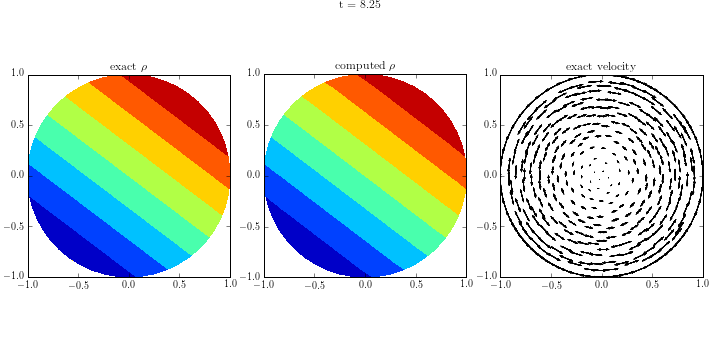
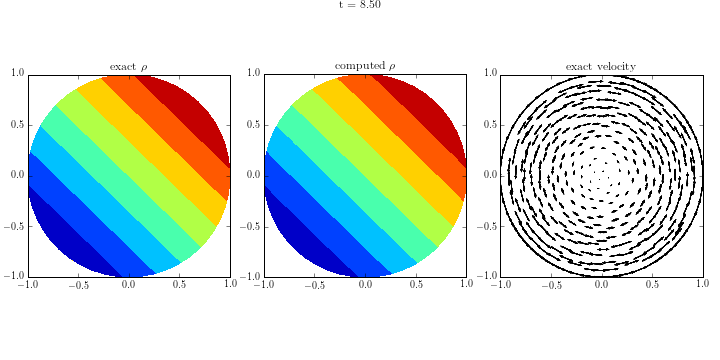
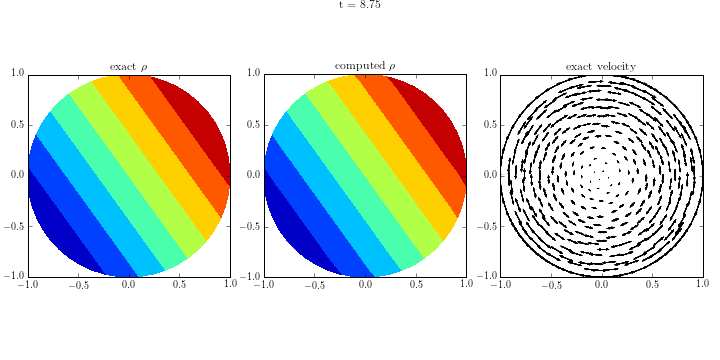
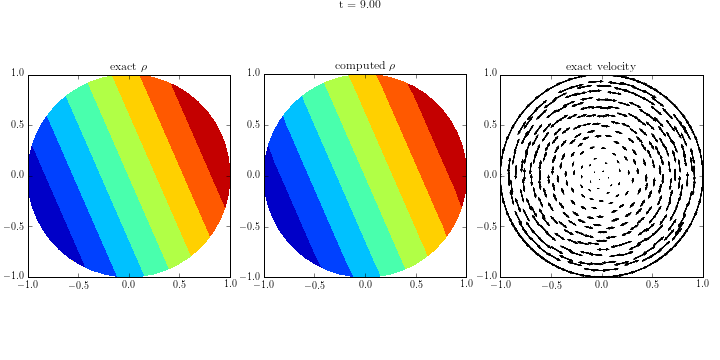
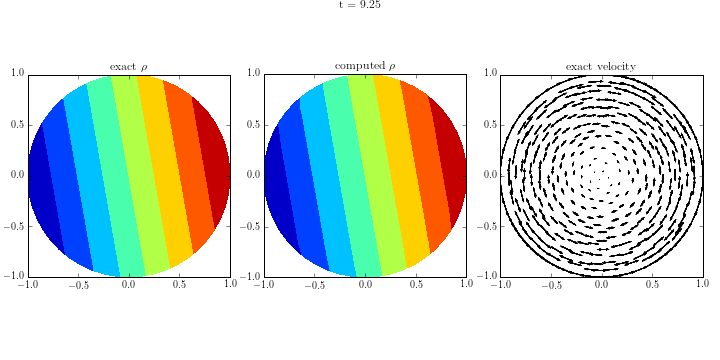
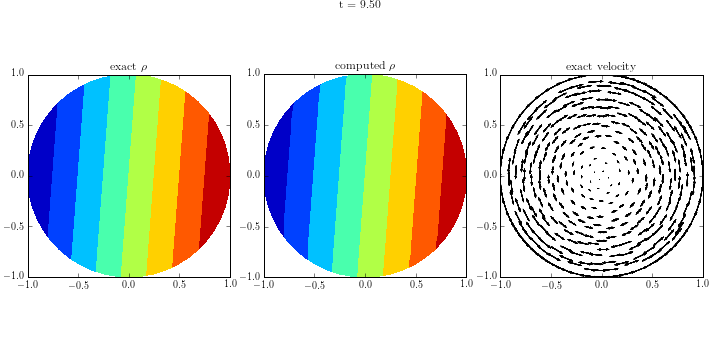
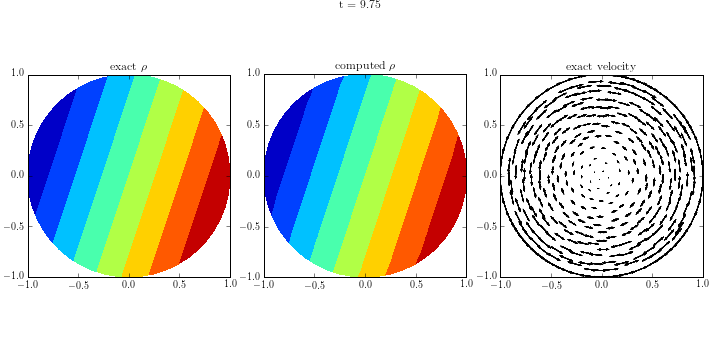
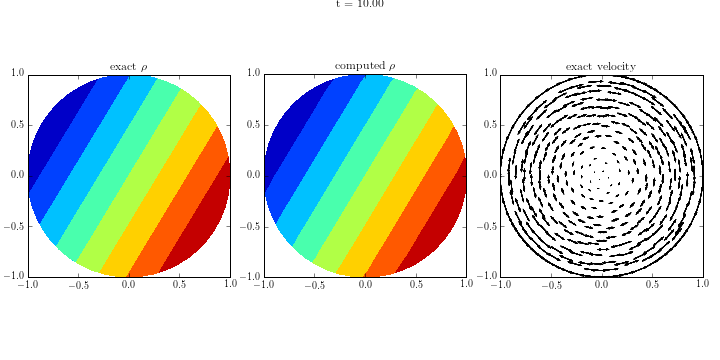

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



# setup subplots for pressure and velocity
fig = plt.figure(figsize=(10,5)) # w, h in inches
# fig.add_axes([0.1, 0.1, 0.6, 0.75])
axerho = fig.add_subplot(131)
axrho = fig.add_subplot(132)
axev = fig.add_subplot(133)

fig.tight_layout() # spread out the plots so that they don't overlap

title = fig.suptitle("",x=0.5, y=1.00,
         horizontalalignment='center',
         fontsize=12,)

# pressure lines and axes
axrho.set_xlim((physics.domain.x[0], physics.domain.x[0]+physics.domain.L[0]))
axrho.set_ylim((physics.domain.x[1], physics.domain.x[1]+physics.domain.L[1])) # un hard code this
nodes = h5.getNode('/nodesSpatial_Domain0')[:]
n = nodes.shape[0]
elements = h5.getNode('/elementsSpatial_Domain0')[:]
rho = h5.getNode('/rho0')[:n]
contour_rho = axrho.tricontourf(nodes[:,0],nodes[:,1],elements,rho)#,label='computed density')
axrho.set_aspect('equal')
contour_rhotrue = axerho.tricontourf(nodes[:,0],nodes[:,1],elements,rhotrue(nodes,0.0),label='computed density')
axerho.set_aspect('equal')
quiver_vtrue = axev.quiver(nodes[:,0],nodes[:,1],utrue(nodes,0),vtrue(nodes,0.0))
axev.set_aspect('equal')
axrho.set_title('computed $\rho$')
axerho.set_title('exact $\rho$')
axev.set_title('exact velocity')

def init():
    contour_rho = axrho.tricontourf(nodes[:,0],nodes[:,1],elements,rho)#,label='computed density')
    axrho.set_aspect('equal')
    return contour_rho

def animate(i):
    # time
    t = numerics.tnList[i]
    title.set_text("t = %.2f" %t)
    
    
    # density
    xrho = h5.getNode("/nodesSpatial_Domain%i" %i)[:]
    n = xrho.shape[0]
    erho = h5.getNode("/elementsSpatial_Domain%i" %i)[:]
    rho_comp = h5.getNode("/rho%i" %i)[:n]
    rho_true = rhotrue(xrho,t)
    u_true = utrue(xrho,t)
    v_true = vtrue(xrho,t)
    contour_rho = axrho.tricontourf(xrho[:,0],xrho[:,1],erho,rho_comp)#,label='computed density')
    axrho.set_aspect('equal')
    contour_rhotrue = axerho.tricontourf(xrho[:,0],xrho[:,1],erho,rho_true)
    axerho.set_aspect('equal')
    quiver_vtrue = axev.quiver(nodes[:,0],nodes[:,1],u_true,v_true)
    axev.set_aspect('equal')
    axrho.set_title('computed $\\rho$')
    axerho.set_title('exact $\\rho$')
    axev.set_title('exact velocity')
        

    plt.show() # force the legends and formatting to show up

    return contour_rho


animation.FuncAnimation(fig, animate, init_func=init,
                        frames=len(numerics.tnList), interval=30, blit=True) # 30 milliseconds between frames  


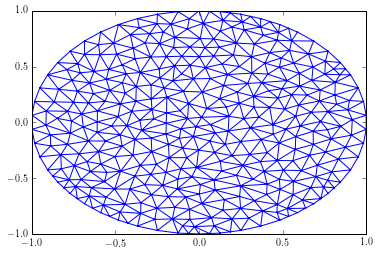

In [10]:
xrho = h5.getNode("/nodesSpatial_Domain%i" %0)[:]
erho = h5.getNode("/elementsSpatial_Domain%i" %0)[:]
plt.triplot(xrho[:,0],xrho[:,1],erho)
# close the table file after extracting all the solutions for the movie above
h5.close()

Compare computed solution to the exact solution, evaluated at the degrees of freedom for the last time step, $T$. Again, only works for C0P1 elements.